In [38]:
import os
import sys
import inspect

# Insert modules directory, TODO create setup.py file
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
reports_dir = os.path.dirname(currentdir)
project_home_dir = os.path.dirname(reports_dir)
sys.path.insert(0, f"{project_home_dir}/qcnn")

In [39]:
import numpy as np
import pandas as pd
from pprint import pprint
from reporting_functions import (
    get_file_content,
    get_result_table,
    get_result_table_target_pairs,
)
from joblib import dump, load
from collections import namedtuple

In [40]:
experiments_path = f"{project_home_dir}/experiments"
experiment_filename = "experiment.json"
target_levels = [
    "classical",
    "country",
    "rock",
    "pop",
    "hiphop",
    "jazz",
    "blues",
    "disco",
    "metal",
    "reggae",
]

In [41]:
experiment_id = 118
experiment_config = get_file_content(
    f"{experiments_path}/{experiment_id}/{experiment_filename}"
)

In [42]:
pprint(experiment_config)

{'ID': 118,
 'data': {'path': '/home/matt/dev/projects/quantum-cnn/data/archive/Data/features_30_sec.csv',
          'sampling': {'random_state': 42, 'test_size': 0.3},
          'target_column': 'label',
          'target_pairs': [['rock', 'reggae'],
                           ['rock', 'blues'],
                           ['classical', 'disco'],
                           ['pop', 'disco']],
          'type': '2d'},
 'extra_info': 'main',
 'model': {'classical': {'cnn': {'ignore': True, 'param_grid': {}},
                         'logistic_regression': {'ignore': False,
                                                 'param_grid': {'C': [0.001,
                                                                      0.01,
                                                                      0.1,
                                                                      1.0,
                                                                      10.0,
                                            

In [43]:
path = f"{experiment_config.get('path')}/{experiment_config.get('ID')}"

In [44]:
y_test = pd.read_csv(f"{path}/y_test.csv", index_col=0)

In [45]:
model_names = [
    filename.split("-model_configuration.joblib")[0]
    for filename in os.listdir(path)
    if "-model_configuration.joblib" in filename
]

In [46]:
# Gather results
Results = namedtuple(
    "Results", ["model_name", "y_test_hat", "clf", "model_configuration", "samples_tfd"]
)
result_list = []
for model_name in model_names:
    y_test_hat = pd.read_csv(f"{path}/{model_name}-yhat.csv", index_col=0)
    clf = load(f"{path}/{model_name}-clf_results.joblib")
    model_configuration = load(f"{path}/{model_name}-model_configuration.joblib")
    samples_tfd = load(f"{path}/{model_name}-samples_tfd.joblib")
    result_list = result_list + [
        Results(
            model_name,
            y_test_hat=y_test_hat,
            clf=clf,
            model_configuration=model_configuration,
            samples_tfd=samples_tfd,
        )
    ]
print(len(result_list))

32


In [47]:
# Table
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

result_data = pd.DataFrame(
    {
        "model_name": [],
        "model_type": [],
        "algorithm": [],
        "classification_type": [],
        "embedding_type": [],
        "scaler_method": [],
        "scaler_param_str": [],
        "selection_method": [],
        "selection_param_str": [],
        "target_pair": [],
        "additional_structure": [],
        "target_pair_str": [],
        "mean_test_score": [],
        "std_test_score": [],
        "params": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "loss_train_history": [],
    }
)
for result in result_list:
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    precision, recall, fscore, support = precision_recall_fscore_support(
        samples_tfd.y_test, y_test_hat, average="binary"  # TODO multiclass
    )
    accuracy = accuracy_score(samples_tfd.y_test, y_test_hat)
    tmp_result = model_configuration._asdict()
    tmp_result["model_name"] = model_name

    tmp_result["target_pair_str"] = "_".join(model_configuration.target_pair)
    tmp_result["mean_test_score"] = clf.cv_results_["mean_test_score"][clf.best_index_]
    tmp_result["std_test_score"] = clf.cv_results_["std_test_score"][clf.best_index_]
    tmp_result["params"] = clf.cv_results_["params"][clf.best_index_]

    tmp_result["accuracy"] = accuracy
    tmp_result["precision"] = precision
    tmp_result["recall"] = recall
    tmp_result["f1"] = fscore
    tmp_result["loss_train_history"] = None  # set for quantum
    result_data = result_data.append(tmp_result, ignore_index=True)

In [53]:
result_data.fillna("None", inplace=True)
result_data.head()

,model_name,model_type,algorithm,classification_type,embedding_type,scaler_method,scaler_param_str,selection_method,selection_param_str,target_pair,additional_structure,target_pair_str,mean_test_score,std_test_score,params,accuracy,precision,recall,f1,loss_train_history
0,classical-logistic_regression-binary-normal-mi...,classical,logistic_regression,binary,normal,minmax,n_components=8,pca,"feature_range=[0, 1]","[pop, disco]",None,pop_disco,0.852956,0.059846,"{'C': 10.0, 'penalty': 'l2'}",0.877193,0.935484,0.852941,0.892308,None
1,quantum-qcnn-binary-IQP-minmax-n_components=8-...,quantum,qcnn,binary,IQP,minmax,n_components=8,pca,"feature_range=[0, 1]","[rock, blues]",custom_0,rock_blues,-18.488241,0.831263,{'n_iter': 50},0.557143,0.700000,0.200000,0.311111,None
2,quantum-qcnn-binary-IQP-minmax-n_components=8-...,quantum,qcnn,binary,IQP,minmax,n_components=8,pca,"feature_range=[0, 1]","[classical, disco]",custom_0,classical_disco,-17.962116,0.953139,{'n_iter': 50},0.611111,0.882353,0.441176,0.588235,None
3,quantum-qcnn-binary-Angle-minmax-n_components=...,quantum,qcnn,binary,Angle,minmax,n_components=8,pca,"feature_range=[0, 1.5707963267948966]","[pop, disco]",custom_0,pop_disco,-10.834337,2.485436,{'n_iter': 50},0.736842,0.913043,0.617647,0.736842,None
4,quantum-qcnn-binary-Angle-minmax-n_components=...,quantum,qcnn,binary,Angle,minmax,n_components=8,pca,"feature_range=[0, 1.5707963267948966]","[rock, blues]","(U_5, psatz1)",rock_blues,-14.325247,1.157624,{'n_iter': 50},0.685714,0.809524,0.485714,0.607143,None


In [55]:
get_result_table(
    result_data,
    ["algorithm", "additional_structure", "target_pair_str"],
    "accuracy",
)

target_pair_str,classical_disco,pop_disco,rock_blues,rock_reggae,algorithm Average
"(logistic_regression, None)",1.000000,0.877193,0.800000,0.812500,0.872423
"(qcnn, (U_5, psatz1))",0.796296,0.578947,0.671429,0.648438,0.673777
"(qcnn, custom_0)",0.805556,0.657895,0.564286,0.734375,0.690528
"(qcnn, custom_1)",0.796296,0.614035,0.600000,0.687500,0.674458
"(svm, None)",0.981481,0.894737,0.842857,0.843750,0.890706
additional_structure Average,0.875926,0.724561,0.695714,0.745313,0.760379


In [56]:
get_result_table(
    result_data,
    ["algorithm", "additional_structure", "target_pair_str"],
    "mean_test_score",
)

target_pair_str,classical_disco,pop_disco,rock_blues,rock_reggae,algorithm Average
"(logistic_regression, None)",0.986207,0.852956,0.830769,0.904233,0.893541
"(qcnn, (U_5, psatz1))",-11.356088,-15.227489,-16.112775,-15.579787,-14.569035
"(qcnn, custom_0)",-11.559142,-15.600248,-16.535691,-14.580209,-14.568822
"(qcnn, custom_1)",-11.165638,-15.591509,-16.359087,-14.874349,-14.497646
"(svm, None)",0.986207,0.839409,0.884615,0.911376,0.905402
additional_structure Average,-6.421691,-8.945376,-9.458434,-8.643747,-8.367312


In [57]:
get_result_table(
    result_data,
    ["algorithm", "additional_structure", "target_pair_str"],
    "std_test_score",
)

target_pair_str,classical_disco,pop_disco,rock_blues,rock_reggae,algorithm Average
"(logistic_regression, None)",0.016893,0.059846,0.062493,0.044721,0.045988
"(qcnn, (U_5, psatz1))",1.284819,1.592825,1.033797,1.696163,1.401901
"(qcnn, custom_0)",1.107291,1.614586,1.189341,0.920580,1.207950
"(qcnn, custom_1)",0.659787,1.495952,1.004151,1.203564,1.090863
"(svm, None)",0.016893,0.059490,0.048650,0.044755,0.042447
additional_structure Average,0.617137,0.964540,0.667686,0.781957,0.757830


In [67]:
#target_pair = ["classical", "disco"]
# target_pair = ["pop", "disco"]
# target_pair = ["rock", "blues"]
target_pair = ["rock", "reggae"]
filtered_results = [
    result
    for result in result_list
    if result.model_configuration.target_pair == target_pair
]
# filtered_results = [
#     result for result in result_list if genre in result.model_configuration.target_pair
# ]

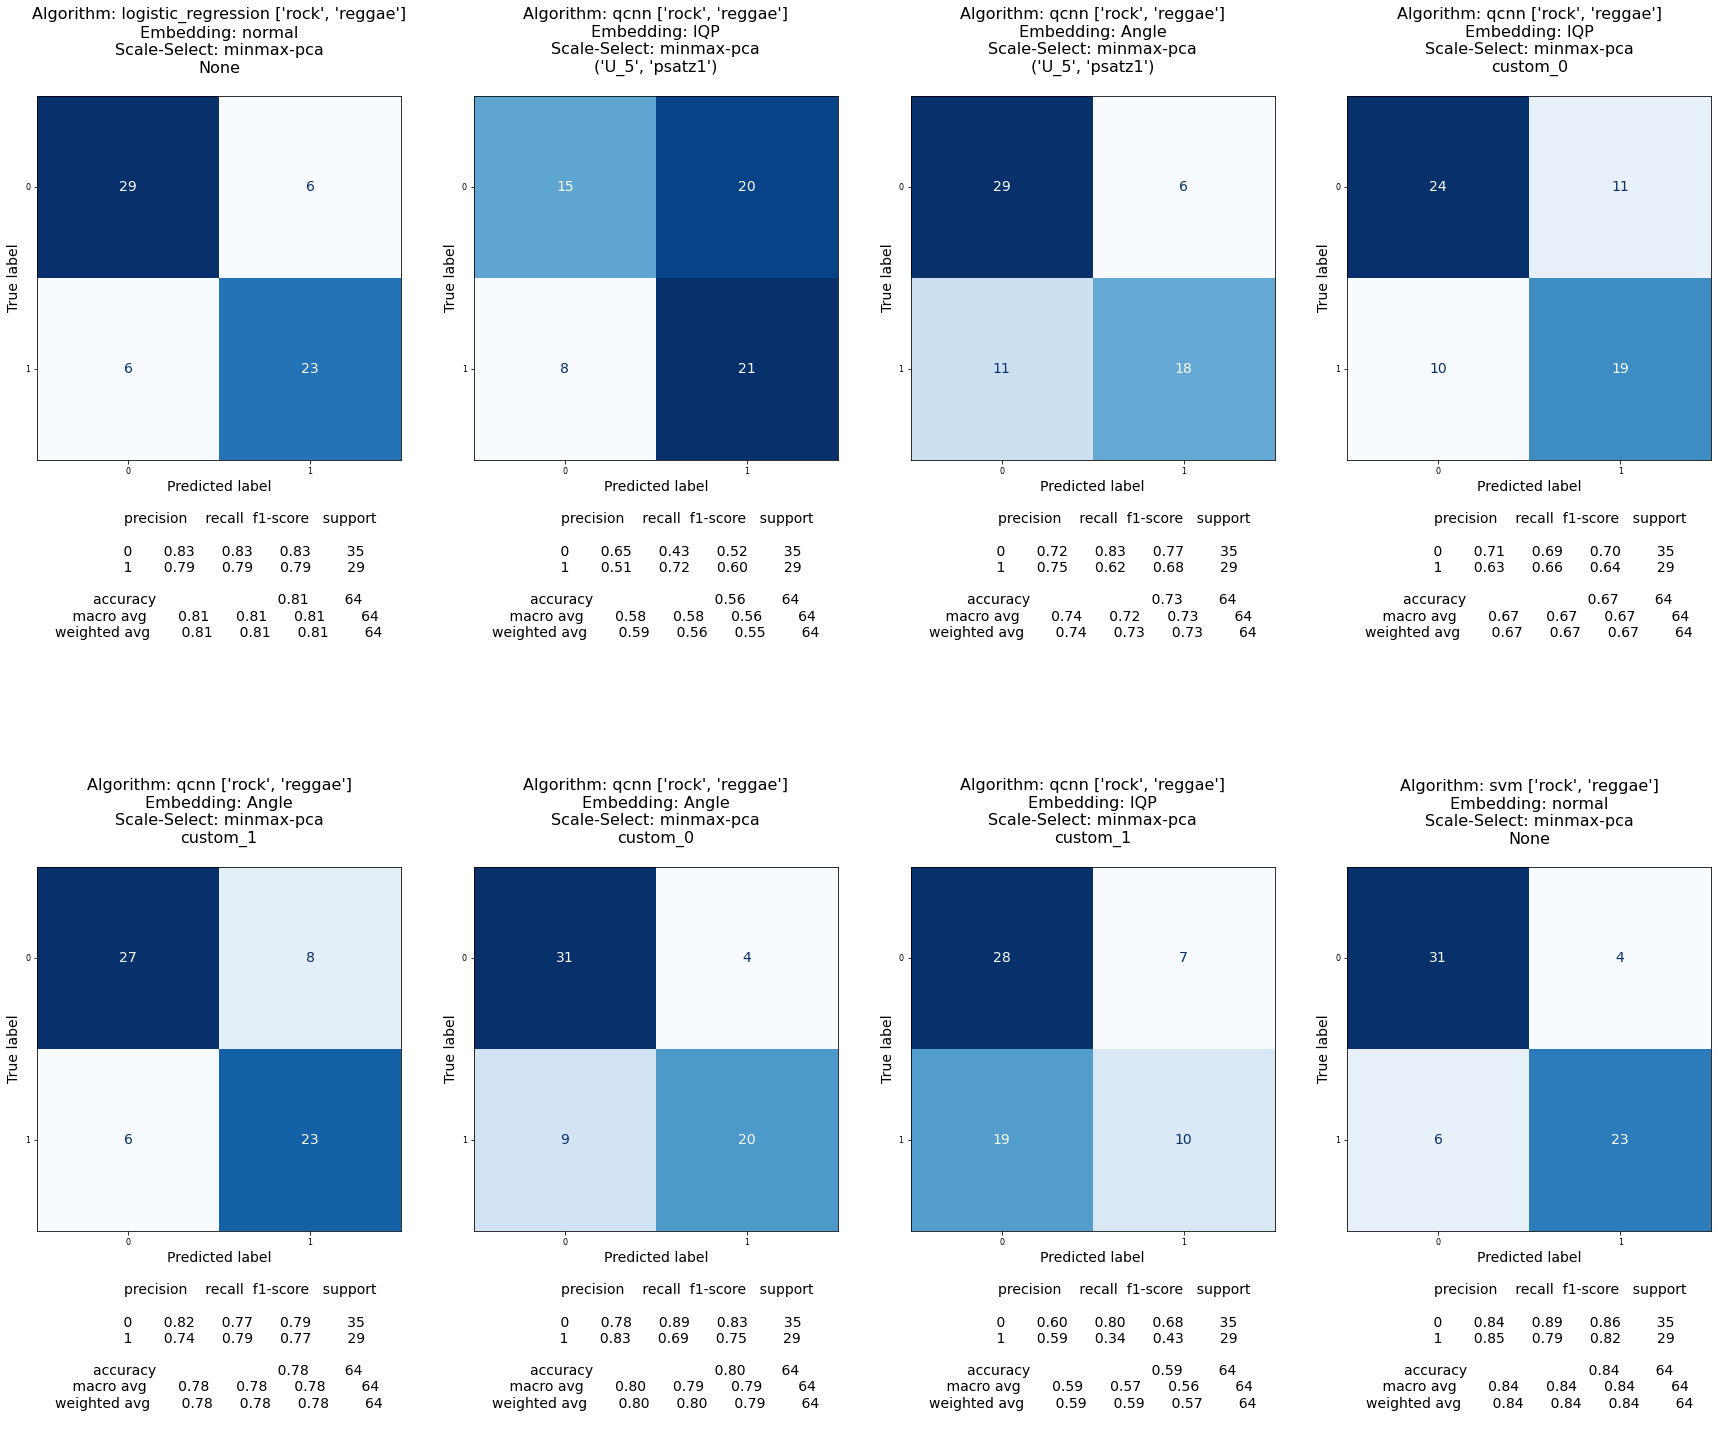

<Figure size 432x288 with 0 Axes>

In [68]:
%matplotlib inline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

# Customize matplotlib
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

row_width = 30
row_height = 13
columns_in_row = 4
n_plots = len(filtered_results)
n_rows = int(np.ceil(n_plots / columns_in_row))
fig, axes = plt.subplots(n_rows, columns_in_row, figsize=(row_width, n_rows * row_height))
for result, i in zip(filtered_results, range(n_plots)):
    col = i % columns_in_row
    row = int(np.floor(i / columns_in_row))
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    display_report = classification_report(samples_tfd.y_test, y_test_hat)
    title_text = (
        f"Algorithm: {model_configuration.algorithm} {model_configuration.target_pair}\n"
        f"Embedding: {model_configuration.embedding_type}\n"
        f"Scale-Select: {model_configuration.scaler_method}-{model_configuration.selection_method}\n"
        f"{model_configuration.additional_structure}\n"
    )
    axes[row, col].grid(False)
    ConfusionMatrixDisplay.from_predictions(
        samples_tfd.y_test, y_test_hat, ax=axes[row, col], cmap=plt.cm.Blues
    )

    axes[row, col].set_title(title_text)
    axes[row, col].set_xlabel(f"Predicted label\n\n{display_report}")
    im = axes[row, col].images
    cb = im[-1].colorbar
    cb.remove()


plt.close()
plt.tight_layout()
fig